# Pothole Segmentation using MaskRCNN with Faster RCNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import os
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import cv2
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks



## Setup

In [ ]:
# Configuration
BATCH_SIZE = 4  # Conservative for L4 GPU memory
NUM_CLASSES = 2  # Background + pothole
LEARNING_RATE = 0.0001
PATIENCE = 5
NUM_EPOCHS = 30

# Define paths
data_dir = "/content/drive/My Drive/Omdena_Pothole/PotholesSegAnnotations_Coco"

# Prepare datasets
train_root = os.path.join(data_dir, "train/")
val_root = os.path.join(data_dir, "valid/")
test_root = os.path.join(data_dir, "test/")

train_annFile = os.path.join(train_root, "_annotations.coco.json")
val_annFile = os.path.join(val_root, "_annotations.coco.json")
test_annFile = os.path.join(test_root, "_annotations.coco.json")


BEST_MODEL_PATH = "/content/drive/My Drive/Omdena_Pothole/Seg_Models/pothole_rcnn_best.pth"


## Data

In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, root, annotation, transforms=None,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.mean = mean
        self.std = std
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = cv2.imread(f"{self.root}/{path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        masks = []
        boxes = []
        for ann in annotations:
            if ann["iscrowd"] == 1:
                mask = maskUtils.decode(ann["segmentation"])
            else:
                mask = coco.annToMask(ann)
            masks.append(mask)

            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

        num_objs = len(annotations)
        if num_objs == 0:
            masks = torch.zeros((0, img.shape[0], img.shape[1]))
            boxes = torch.zeros((0, 4))
        else:
            masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {
            "boxes": boxes,
            "labels": torch.ones((num_objs,), dtype=torch.int64),
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((num_objs,), dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        # Normalize the image here
        img = F.normalize(F.to_tensor(img), mean=self.mean, std=self.std)


        return img, target

    def __len__(self):
        return len(self.ids)


In [ ]:
def get_model():
    # Load pre-trained Mask R-CNN
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Replace box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

    # Replace mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


## Train

## Eval on Valid set

In [ ]:
# Replace validation loop with metric calculation
from torchmetrics.detection import MeanAveragePrecision

def validate(model, val_loader, device):
    model.eval()
    metric = MeanAveragePrecision().to(device)

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            outputs = model(images)

            # Convert ground truth and predictions to metric format
            metric.update(outputs, targets)

    # Calculate final mAP
    result = metric.compute()
    return result['map']


# Start Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Data loading
train_dataset = PotholeDataset(train_root, train_annFile)
val_dataset = PotholeDataset(val_root,val_annFile)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                        collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=lambda x: tuple(zip(*x)))

model = get_model().to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

best_loss = float('inf')
patience_counter = 0


loading annotations into memory...
Done (t=4.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 97.7MB/s]


In [ ]:
from tqdm import tqdm
print_freq = 10
best_map = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0


    #for images, targets in train_loader:
    for i, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

        if (i + 1) % print_freq == 0:
            print(f"  Batch {i + 1}/{len(train_loader)}: Loss: {losses.item():.4f} ")

    # Validation
    current_map = validate(model, val_loader, device)
    print(f"Epoch {epoch+1}: mAP = {current_map:.4f}")

    # Early stopping and LR scheduling
    #scheduler.step(avg_val_loss)

    if current_map  > best_map:
        print(f"mAP improved from {best_map:.4f} to {current_map:.4f}")
        best_map = current_map
        patience_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs. Best mAP {best_map:.4f}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break



Epoch 1:   5%|▍         | 10/217 [00:34<11:08,  3.23s/it]

  Batch 10/217: Loss: 0.8288 


Epoch 1:   9%|▉         | 20/217 [01:04<09:46,  2.98s/it]

  Batch 20/217: Loss: 0.9026 


Epoch 1:  14%|█▍        | 30/217 [01:35<09:22,  3.01s/it]

  Batch 30/217: Loss: 0.9751 


Epoch 1:  18%|█▊        | 40/217 [02:05<08:34,  2.91s/it]

  Batch 40/217: Loss: 0.9135 


Epoch 1:  23%|██▎       | 50/217 [02:35<08:54,  3.20s/it]

  Batch 50/217: Loss: 1.0013 


Epoch 1:  28%|██▊       | 60/217 [03:17<09:36,  3.67s/it]

  Batch 60/217: Loss: 0.9318 


Epoch 1:  32%|███▏      | 70/217 [03:48<07:16,  2.97s/it]

  Batch 70/217: Loss: 0.9675 


Epoch 1:  37%|███▋      | 80/217 [04:38<11:21,  4.97s/it]

  Batch 80/217: Loss: 0.8531 


Epoch 1:  41%|████▏     | 90/217 [05:12<06:28,  3.06s/it]

  Batch 90/217: Loss: 0.5619 


Epoch 1:  46%|████▌     | 100/217 [05:42<06:00,  3.08s/it]

  Batch 100/217: Loss: 0.9563 


Epoch 1:  51%|█████     | 110/217 [06:14<05:23,  3.02s/it]

  Batch 110/217: Loss: 0.5402 


Epoch 1:  55%|█████▌    | 120/217 [06:44<04:57,  3.07s/it]

  Batch 120/217: Loss: 1.2156 


Epoch 1:  60%|█████▉    | 130/217 [07:17<05:04,  3.50s/it]

  Batch 130/217: Loss: 0.6037 


Epoch 1:  65%|██████▍   | 140/217 [07:48<03:52,  3.02s/it]

  Batch 140/217: Loss: 1.0337 


Epoch 1:  69%|██████▉   | 150/217 [08:20<03:48,  3.40s/it]

  Batch 150/217: Loss: 0.6785 


Epoch 1:  74%|███████▎  | 160/217 [08:54<02:59,  3.14s/it]

  Batch 160/217: Loss: 0.6319 


Epoch 1:  78%|███████▊  | 170/217 [09:24<02:15,  2.88s/it]

  Batch 170/217: Loss: 0.5945 


Epoch 1:  83%|████████▎ | 180/217 [09:53<01:49,  2.95s/it]

  Batch 180/217: Loss: 0.5714 


Epoch 1:  88%|████████▊ | 190/217 [10:27<01:35,  3.55s/it]

  Batch 190/217: Loss: 0.7223 


Epoch 1:  92%|█████████▏| 200/217 [10:59<00:56,  3.31s/it]

  Batch 200/217: Loss: 0.4930 


Epoch 1:  97%|█████████▋| 210/217 [11:30<00:20,  2.87s/it]

  Batch 210/217: Loss: 0.6009 


Evaluating: 100%|██████████| 62/62 [02:55<00:00,  2.82s/it]


Epoch 1: mAP = 0.2404
mAP improved from 0.0000 to 0.2404


Epoch 2:   5%|▍         | 10/217 [00:04<01:34,  2.18it/s]

  Batch 10/217: Loss: 0.8056 


Epoch 2:   9%|▉         | 20/217 [00:09<01:28,  2.22it/s]

  Batch 20/217: Loss: 0.8447 


Epoch 2:  14%|█▍        | 30/217 [00:13<01:21,  2.29it/s]

  Batch 30/217: Loss: 0.8292 


Epoch 2:  18%|█▊        | 40/217 [00:18<01:18,  2.24it/s]

  Batch 40/217: Loss: 0.7891 


Epoch 2:  23%|██▎       | 50/217 [00:22<01:14,  2.25it/s]

  Batch 50/217: Loss: 0.9419 


Epoch 2:  28%|██▊       | 60/217 [00:26<01:08,  2.29it/s]

  Batch 60/217: Loss: 0.5231 


Epoch 2:  32%|███▏      | 70/217 [00:31<01:03,  2.30it/s]

  Batch 70/217: Loss: 0.5841 


Epoch 2:  37%|███▋      | 80/217 [00:35<00:58,  2.35it/s]

  Batch 80/217: Loss: 0.6693 


Epoch 2:  41%|████▏     | 90/217 [00:39<00:58,  2.17it/s]

  Batch 90/217: Loss: 0.7542 


Epoch 2:  46%|████▌     | 100/217 [00:44<00:51,  2.29it/s]

  Batch 100/217: Loss: 0.4772 


Epoch 2:  51%|█████     | 110/217 [00:48<00:46,  2.32it/s]

  Batch 110/217: Loss: 0.4900 


Epoch 2:  55%|█████▌    | 120/217 [00:52<00:41,  2.36it/s]

  Batch 120/217: Loss: 0.5972 


Epoch 2:  60%|█████▉    | 130/217 [00:57<00:36,  2.38it/s]

  Batch 130/217: Loss: 0.3576 


Epoch 2:  65%|██████▍   | 140/217 [01:01<00:34,  2.24it/s]

  Batch 140/217: Loss: 0.6150 


Epoch 2:  69%|██████▉   | 150/217 [01:05<00:29,  2.28it/s]

  Batch 150/217: Loss: 0.4439 


Epoch 2:  74%|███████▎  | 160/217 [01:10<00:25,  2.21it/s]

  Batch 160/217: Loss: 0.6537 


Epoch 2:  78%|███████▊  | 170/217 [01:14<00:20,  2.34it/s]

  Batch 170/217: Loss: 0.6465 


Epoch 2:  83%|████████▎ | 180/217 [01:18<00:16,  2.22it/s]

  Batch 180/217: Loss: 0.8627 


Epoch 2:  88%|████████▊ | 190/217 [01:23<00:11,  2.33it/s]

  Batch 190/217: Loss: 0.4563 


Epoch 2:  92%|█████████▏| 200/217 [01:27<00:07,  2.38it/s]

  Batch 200/217: Loss: 0.5369 


Epoch 2:  97%|█████████▋| 210/217 [01:31<00:03,  2.30it/s]

  Batch 210/217: Loss: 0.6873 


Evaluating: 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]


Epoch 2: mAP = 0.2643
mAP improved from 0.2404 to 0.2643


Epoch 3:   5%|▍         | 10/217 [00:04<01:30,  2.29it/s]

  Batch 10/217: Loss: 0.5550 


Epoch 3:   9%|▉         | 20/217 [00:08<01:27,  2.24it/s]

  Batch 20/217: Loss: 0.5807 


Epoch 3:  14%|█▍        | 30/217 [00:13<01:25,  2.19it/s]

  Batch 30/217: Loss: 0.3360 


Epoch 3:  18%|█▊        | 40/217 [00:17<01:15,  2.36it/s]

  Batch 40/217: Loss: 0.3746 


Epoch 3:  23%|██▎       | 50/217 [00:22<01:14,  2.23it/s]

  Batch 50/217: Loss: 0.6299 


Epoch 3:  28%|██▊       | 60/217 [00:26<01:09,  2.26it/s]

  Batch 60/217: Loss: 0.4585 


Epoch 3:  32%|███▏      | 70/217 [00:30<01:01,  2.40it/s]

  Batch 70/217: Loss: 0.3537 


Epoch 3:  37%|███▋      | 80/217 [00:35<01:00,  2.25it/s]

  Batch 80/217: Loss: 0.6607 


Epoch 3:  41%|████▏     | 90/217 [00:39<00:55,  2.28it/s]

  Batch 90/217: Loss: 0.4252 


Epoch 3:  46%|████▌     | 100/217 [00:43<00:51,  2.27it/s]

  Batch 100/217: Loss: 0.5845 


Epoch 3:  51%|█████     | 110/217 [00:48<00:45,  2.36it/s]

  Batch 110/217: Loss: 0.4876 


Epoch 3:  55%|█████▌    | 120/217 [00:52<00:42,  2.29it/s]

  Batch 120/217: Loss: 0.5846 


Epoch 3:  60%|█████▉    | 130/217 [00:56<00:37,  2.33it/s]

  Batch 130/217: Loss: 0.3178 


Epoch 3:  65%|██████▍   | 140/217 [01:00<00:32,  2.38it/s]

  Batch 140/217: Loss: 0.2953 


Epoch 3:  69%|██████▉   | 150/217 [01:05<00:29,  2.29it/s]

  Batch 150/217: Loss: 0.5845 


Epoch 3:  74%|███████▎  | 160/217 [01:09<00:24,  2.34it/s]

  Batch 160/217: Loss: 0.4956 


Epoch 3:  78%|███████▊  | 170/217 [01:13<00:20,  2.35it/s]

  Batch 170/217: Loss: 0.4391 


Epoch 3:  83%|████████▎ | 180/217 [01:18<00:16,  2.31it/s]

  Batch 180/217: Loss: 0.2923 


Epoch 3:  88%|████████▊ | 190/217 [01:22<00:12,  2.19it/s]

  Batch 190/217: Loss: 0.6863 


Epoch 3:  92%|█████████▏| 200/217 [01:27<00:07,  2.25it/s]

  Batch 200/217: Loss: 0.7575 


Epoch 3:  97%|█████████▋| 210/217 [01:31<00:02,  2.37it/s]

  Batch 210/217: Loss: 0.4249 


Evaluating: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


Epoch 3: mAP = 0.2970
mAP improved from 0.2643 to 0.2970


Epoch 4:   5%|▍         | 10/217 [00:05<01:33,  2.21it/s]

  Batch 10/217: Loss: 0.5054 


Epoch 4:   9%|▉         | 20/217 [00:09<01:22,  2.37it/s]

  Batch 20/217: Loss: 0.4372 


Epoch 4:  14%|█▍        | 30/217 [00:13<01:25,  2.20it/s]

  Batch 30/217: Loss: 0.3748 


Epoch 4:  18%|█▊        | 40/217 [00:18<01:18,  2.24it/s]

  Batch 40/217: Loss: 0.3351 


Epoch 4:  23%|██▎       | 50/217 [00:22<01:13,  2.27it/s]

  Batch 50/217: Loss: 0.3413 


Epoch 4:  28%|██▊       | 60/217 [00:27<01:09,  2.26it/s]

  Batch 60/217: Loss: 0.6122 


Epoch 4:  32%|███▏      | 70/217 [00:31<01:03,  2.30it/s]

  Batch 70/217: Loss: 0.3569 


Epoch 4:  37%|███▋      | 80/217 [00:35<00:59,  2.30it/s]

  Batch 80/217: Loss: 0.4075 


Epoch 4:  41%|████▏     | 90/217 [00:39<00:54,  2.35it/s]

  Batch 90/217: Loss: 0.4753 


Epoch 4:  46%|████▌     | 100/217 [00:44<00:51,  2.27it/s]

  Batch 100/217: Loss: 0.5232 


Epoch 4:  51%|█████     | 110/217 [00:48<00:47,  2.27it/s]

  Batch 110/217: Loss: 0.6129 


Epoch 4:  55%|█████▌    | 120/217 [00:53<00:43,  2.24it/s]

  Batch 120/217: Loss: 0.5552 


Epoch 4:  60%|█████▉    | 130/217 [00:57<00:39,  2.18it/s]

  Batch 130/217: Loss: 0.4416 


Epoch 4:  65%|██████▍   | 140/217 [01:01<00:32,  2.36it/s]

  Batch 140/217: Loss: 0.5795 


Epoch 4:  69%|██████▉   | 150/217 [01:06<00:29,  2.30it/s]

  Batch 150/217: Loss: 0.4568 


Epoch 4:  74%|███████▎  | 160/217 [01:10<00:24,  2.29it/s]

  Batch 160/217: Loss: 0.6499 


Epoch 4:  78%|███████▊  | 170/217 [01:14<00:20,  2.34it/s]

  Batch 170/217: Loss: 0.4355 


Epoch 4:  83%|████████▎ | 180/217 [01:19<00:16,  2.24it/s]

  Batch 180/217: Loss: 0.5223 


Epoch 4:  88%|████████▊ | 190/217 [01:23<00:11,  2.31it/s]

  Batch 190/217: Loss: 0.2838 


Epoch 4:  92%|█████████▏| 200/217 [01:27<00:07,  2.29it/s]

  Batch 200/217: Loss: 0.4744 


Epoch 4:  97%|█████████▋| 210/217 [01:32<00:03,  2.29it/s]

  Batch 210/217: Loss: 0.4438 


Evaluating: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


Epoch 4: mAP = 0.3094
mAP improved from 0.2970 to 0.3094


Epoch 5:   5%|▍         | 10/217 [00:05<01:34,  2.19it/s]

  Batch 10/217: Loss: 0.2990 


Epoch 5:   9%|▉         | 20/217 [00:09<01:25,  2.30it/s]

  Batch 20/217: Loss: 0.2631 


Epoch 5:  14%|█▍        | 30/217 [00:13<01:22,  2.25it/s]

  Batch 30/217: Loss: 0.3392 


Epoch 5:  18%|█▊        | 40/217 [00:18<01:16,  2.32it/s]

  Batch 40/217: Loss: 0.5355 


Epoch 5:  23%|██▎       | 50/217 [00:22<01:12,  2.29it/s]

  Batch 50/217: Loss: 0.3570 


Epoch 5:  28%|██▊       | 60/217 [00:27<01:08,  2.30it/s]

  Batch 60/217: Loss: 0.3564 


Epoch 5:  32%|███▏      | 70/217 [00:31<01:04,  2.27it/s]

  Batch 70/217: Loss: 0.4598 


Epoch 5:  37%|███▋      | 80/217 [00:35<00:58,  2.35it/s]

  Batch 80/217: Loss: 0.2713 


Epoch 5:  41%|████▏     | 90/217 [00:40<00:53,  2.35it/s]

  Batch 90/217: Loss: 0.3149 


Epoch 5:  46%|████▌     | 100/217 [00:44<00:53,  2.19it/s]

  Batch 100/217: Loss: 0.4352 


Epoch 5:  51%|█████     | 110/217 [00:48<00:45,  2.36it/s]

  Batch 110/217: Loss: 0.1995 


Epoch 5:  55%|█████▌    | 120/217 [00:53<00:43,  2.24it/s]

  Batch 120/217: Loss: 0.2664 


Epoch 5:  60%|█████▉    | 130/217 [00:57<00:39,  2.23it/s]

  Batch 130/217: Loss: 0.3977 


Epoch 5:  65%|██████▍   | 140/217 [01:02<00:33,  2.29it/s]

  Batch 140/217: Loss: 0.4357 


Epoch 5:  69%|██████▉   | 150/217 [01:06<00:30,  2.21it/s]

  Batch 150/217: Loss: 0.4074 


Epoch 5:  74%|███████▎  | 160/217 [01:10<00:26,  2.18it/s]

  Batch 160/217: Loss: 0.6744 


Epoch 5:  78%|███████▊  | 170/217 [01:15<00:20,  2.25it/s]

  Batch 170/217: Loss: 0.5925 


Epoch 5:  83%|████████▎ | 180/217 [01:19<00:16,  2.28it/s]

  Batch 180/217: Loss: 0.5051 


Epoch 5:  88%|████████▊ | 190/217 [01:23<00:11,  2.35it/s]

  Batch 190/217: Loss: 0.3867 


Epoch 5:  92%|█████████▏| 200/217 [01:28<00:07,  2.30it/s]

  Batch 200/217: Loss: 0.3855 


Epoch 5:  97%|█████████▋| 210/217 [01:32<00:03,  2.26it/s]

  Batch 210/217: Loss: 0.4326 


Evaluating: 100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Epoch 5: mAP = 0.3129
mAP improved from 0.3094 to 0.3129


Epoch 6:   5%|▍         | 10/217 [00:04<01:33,  2.22it/s]

  Batch 10/217: Loss: 0.3855 


Epoch 6:   9%|▉         | 20/217 [00:09<01:25,  2.29it/s]

  Batch 20/217: Loss: 0.3115 


Epoch 6:  14%|█▍        | 30/217 [00:13<01:26,  2.16it/s]

  Batch 30/217: Loss: 0.5590 


Epoch 6:  18%|█▊        | 40/217 [00:18<01:17,  2.29it/s]

  Batch 40/217: Loss: 0.3090 


Epoch 6:  23%|██▎       | 50/217 [00:22<01:12,  2.30it/s]

  Batch 50/217: Loss: 0.3411 


Epoch 6:  28%|██▊       | 60/217 [00:26<01:09,  2.26it/s]

  Batch 60/217: Loss: 0.3618 


Epoch 6:  32%|███▏      | 70/217 [00:31<01:03,  2.31it/s]

  Batch 70/217: Loss: 0.2861 


Epoch 6:  37%|███▋      | 80/217 [00:35<00:59,  2.30it/s]

  Batch 80/217: Loss: 0.2722 


Epoch 6:  41%|████▏     | 90/217 [00:40<00:58,  2.19it/s]

  Batch 90/217: Loss: 0.4980 


Epoch 6:  46%|████▌     | 100/217 [00:44<00:51,  2.26it/s]

  Batch 100/217: Loss: 0.2511 


Epoch 6:  51%|█████     | 110/217 [00:49<00:46,  2.31it/s]

  Batch 110/217: Loss: 0.2943 


Epoch 6:  55%|█████▌    | 120/217 [00:53<00:43,  2.24it/s]

  Batch 120/217: Loss: 0.4982 


Epoch 6:  60%|█████▉    | 130/217 [00:57<00:37,  2.32it/s]

  Batch 130/217: Loss: 0.1946 


Epoch 6:  65%|██████▍   | 140/217 [01:02<00:33,  2.32it/s]

  Batch 140/217: Loss: 0.3329 


Epoch 6:  69%|██████▉   | 150/217 [01:06<00:28,  2.35it/s]

  Batch 150/217: Loss: 0.2280 


Epoch 6:  74%|███████▎  | 160/217 [01:10<00:24,  2.37it/s]

  Batch 160/217: Loss: 0.3561 


Epoch 6:  78%|███████▊  | 170/217 [01:15<00:20,  2.27it/s]

  Batch 170/217: Loss: 0.5429 


Epoch 6:  83%|████████▎ | 180/217 [01:19<00:16,  2.26it/s]

  Batch 180/217: Loss: 0.2786 


Epoch 6:  88%|████████▊ | 190/217 [01:23<00:11,  2.26it/s]

  Batch 190/217: Loss: 0.5224 


Epoch 6:  92%|█████████▏| 200/217 [01:28<00:07,  2.29it/s]

  Batch 200/217: Loss: 0.5104 


Epoch 6:  97%|█████████▋| 210/217 [01:32<00:03,  2.21it/s]

  Batch 210/217: Loss: 0.4285 


Evaluating: 100%|██████████| 62/62 [00:14<00:00,  4.18it/s]


Epoch 6: mAP = 0.3297
mAP improved from 0.3129 to 0.3297


Epoch 7:   5%|▍         | 10/217 [00:04<01:38,  2.10it/s]

  Batch 10/217: Loss: 0.4061 


Epoch 7:   9%|▉         | 20/217 [00:09<01:25,  2.30it/s]

  Batch 20/217: Loss: 0.2378 


Epoch 7:  14%|█▍        | 30/217 [00:13<01:21,  2.30it/s]

  Batch 30/217: Loss: 0.3223 


Epoch 7:  18%|█▊        | 40/217 [00:17<01:17,  2.27it/s]

  Batch 40/217: Loss: 0.2247 


Epoch 7:  23%|██▎       | 50/217 [00:22<01:13,  2.28it/s]

  Batch 50/217: Loss: 0.2407 


Epoch 7:  28%|██▊       | 60/217 [00:26<01:07,  2.33it/s]

  Batch 60/217: Loss: 0.2376 


Epoch 7:  32%|███▏      | 70/217 [00:31<01:05,  2.24it/s]

  Batch 70/217: Loss: 0.3126 


Epoch 7:  37%|███▋      | 80/217 [00:35<00:58,  2.34it/s]

  Batch 80/217: Loss: 0.2439 


Epoch 7:  41%|████▏     | 90/217 [00:39<00:56,  2.25it/s]

  Batch 90/217: Loss: 0.2309 


Epoch 7:  46%|████▌     | 100/217 [00:44<00:51,  2.25it/s]

  Batch 100/217: Loss: 0.3186 


Epoch 7:  51%|█████     | 110/217 [00:48<00:48,  2.22it/s]

  Batch 110/217: Loss: 0.3902 


Epoch 7:  55%|█████▌    | 120/217 [00:53<00:42,  2.27it/s]

  Batch 120/217: Loss: 0.2502 


Epoch 7:  60%|█████▉    | 130/217 [00:57<00:37,  2.34it/s]

  Batch 130/217: Loss: 0.2785 


Epoch 7:  65%|██████▍   | 140/217 [01:02<00:33,  2.27it/s]

  Batch 140/217: Loss: 0.2595 


Epoch 7:  69%|██████▉   | 150/217 [01:06<00:28,  2.39it/s]

  Batch 150/217: Loss: 0.1530 


Epoch 7:  74%|███████▎  | 160/217 [01:10<00:26,  2.14it/s]

  Batch 160/217: Loss: 0.4666 


Epoch 7:  78%|███████▊  | 170/217 [01:15<00:19,  2.36it/s]

  Batch 170/217: Loss: 0.3229 


Epoch 7:  83%|████████▎ | 180/217 [01:19<00:16,  2.31it/s]

  Batch 180/217: Loss: 0.3032 


Epoch 7:  88%|████████▊ | 190/217 [01:23<00:11,  2.31it/s]

  Batch 190/217: Loss: 0.1886 


Epoch 7:  92%|█████████▏| 200/217 [01:28<00:07,  2.35it/s]

  Batch 200/217: Loss: 0.2596 


Epoch 7:  97%|█████████▋| 210/217 [01:32<00:03,  2.28it/s]

  Batch 210/217: Loss: 0.4407 


Evaluating: 100%|██████████| 62/62 [00:14<00:00,  4.25it/s]


Epoch 7: mAP = 0.3169
No improvement for 1 epochs. Best mAP 0.3297


Epoch 8:   5%|▍         | 10/217 [00:04<01:29,  2.30it/s]

  Batch 10/217: Loss: 0.2308 


Epoch 8:   9%|▉         | 20/217 [00:08<01:31,  2.14it/s]

  Batch 20/217: Loss: 0.4520 


Epoch 8:  14%|█▍        | 30/217 [00:13<01:20,  2.31it/s]

  Batch 30/217: Loss: 0.1802 


Epoch 8:  18%|█▊        | 40/217 [00:17<01:17,  2.29it/s]

  Batch 40/217: Loss: 0.1469 


Epoch 8:  23%|██▎       | 50/217 [00:22<01:16,  2.18it/s]

  Batch 50/217: Loss: 0.2512 


Epoch 8:  28%|██▊       | 60/217 [00:26<01:11,  2.19it/s]

  Batch 60/217: Loss: 0.4957 


Epoch 8:  32%|███▏      | 70/217 [00:31<01:06,  2.22it/s]

  Batch 70/217: Loss: 0.3749 


Epoch 8:  37%|███▋      | 80/217 [00:35<01:02,  2.20it/s]

  Batch 80/217: Loss: 0.2831 


Epoch 8:  41%|████▏     | 90/217 [00:39<00:55,  2.31it/s]

  Batch 90/217: Loss: 0.2004 


Epoch 8:  46%|████▌     | 100/217 [00:44<00:50,  2.31it/s]

  Batch 100/217: Loss: 0.1931 


Epoch 8:  51%|█████     | 110/217 [00:48<00:46,  2.29it/s]

  Batch 110/217: Loss: 0.3342 


Epoch 8:  55%|█████▌    | 120/217 [00:52<00:41,  2.33it/s]

  Batch 120/217: Loss: 0.2044 


Epoch 8:  60%|█████▉    | 130/217 [00:57<00:37,  2.32it/s]

  Batch 130/217: Loss: 0.1347 


Epoch 8:  65%|██████▍   | 140/217 [01:01<00:33,  2.28it/s]

  Batch 140/217: Loss: 0.2262 


Epoch 8:  69%|██████▉   | 150/217 [01:06<00:29,  2.26it/s]

  Batch 150/217: Loss: 0.4894 


Epoch 8:  74%|███████▎  | 160/217 [01:10<00:25,  2.27it/s]

  Batch 160/217: Loss: 0.3332 


Epoch 8:  78%|███████▊  | 170/217 [01:14<00:20,  2.31it/s]

  Batch 170/217: Loss: 0.1892 


Epoch 8:  83%|████████▎ | 180/217 [01:19<00:16,  2.27it/s]

  Batch 180/217: Loss: 0.3612 


Epoch 8:  88%|████████▊ | 190/217 [01:23<00:11,  2.28it/s]

  Batch 190/217: Loss: 0.2534 


Epoch 8:  92%|█████████▏| 200/217 [01:28<00:07,  2.23it/s]

  Batch 200/217: Loss: 0.2321 


Epoch 8:  97%|█████████▋| 210/217 [01:32<00:03,  2.32it/s]

  Batch 210/217: Loss: 0.2432 


Evaluating: 100%|██████████| 62/62 [00:14<00:00,  4.26it/s]


Epoch 8: mAP = 0.3317
mAP improved from 0.3297 to 0.3317


Epoch 9:   5%|▍         | 10/217 [00:04<01:30,  2.30it/s]

  Batch 10/217: Loss: 0.3296 


Epoch 9:   9%|▉         | 20/217 [00:08<01:28,  2.23it/s]

  Batch 20/217: Loss: 0.3469 


Epoch 9:  14%|█▍        | 30/217 [00:13<01:25,  2.20it/s]

  Batch 30/217: Loss: 0.4686 


Epoch 9:  18%|█▊        | 40/217 [00:17<01:18,  2.26it/s]

  Batch 40/217: Loss: 0.4438 


Epoch 9:  23%|██▎       | 50/217 [00:21<01:12,  2.32it/s]

  Batch 50/217: Loss: 0.3271 


Epoch 9:  28%|██▊       | 60/217 [00:26<01:08,  2.29it/s]

  Batch 60/217: Loss: 0.2169 


Epoch 9:  32%|███▏      | 70/217 [00:30<01:07,  2.19it/s]

  Batch 70/217: Loss: 0.2348 


Epoch 9:  37%|███▋      | 80/217 [00:35<01:01,  2.24it/s]

  Batch 80/217: Loss: 0.2875 


Epoch 9:  41%|████▏     | 90/217 [00:39<00:58,  2.17it/s]

  Batch 90/217: Loss: 0.3396 


Epoch 9:  46%|████▌     | 100/217 [00:44<00:52,  2.23it/s]

  Batch 100/217: Loss: 0.1210 


Epoch 9:  51%|█████     | 110/217 [00:48<00:47,  2.25it/s]

  Batch 110/217: Loss: 0.2188 


Epoch 9:  55%|█████▌    | 120/217 [00:53<00:46,  2.08it/s]

  Batch 120/217: Loss: 0.4342 


Epoch 9:  60%|█████▉    | 130/217 [00:57<00:37,  2.30it/s]

  Batch 130/217: Loss: 0.1591 


Epoch 9:  65%|██████▍   | 140/217 [01:01<00:33,  2.29it/s]

  Batch 140/217: Loss: 0.2219 


Epoch 9:  69%|██████▉   | 150/217 [01:06<00:29,  2.29it/s]

  Batch 150/217: Loss: 0.2028 


Epoch 9:  74%|███████▎  | 160/217 [01:10<00:25,  2.24it/s]

  Batch 160/217: Loss: 0.2957 


Epoch 9:  78%|███████▊  | 170/217 [01:15<00:20,  2.24it/s]

  Batch 170/217: Loss: 0.2675 


Epoch 9:  83%|████████▎ | 180/217 [01:19<00:16,  2.26it/s]

  Batch 180/217: Loss: 0.2810 


Epoch 9:  88%|████████▊ | 190/217 [01:23<00:11,  2.30it/s]

  Batch 190/217: Loss: 0.2095 


Epoch 9:  92%|█████████▏| 200/217 [01:28<00:07,  2.30it/s]

  Batch 200/217: Loss: 0.2266 


Epoch 9:  97%|█████████▋| 210/217 [01:32<00:03,  2.24it/s]

  Batch 210/217: Loss: 0.2972 


Evaluating: 100%|██████████| 62/62 [00:14<00:00,  4.39it/s]


Epoch 9: mAP = 0.3371
mAP improved from 0.3317 to 0.3371


Epoch 10:   5%|▍         | 10/217 [00:04<01:32,  2.24it/s]

  Batch 10/217: Loss: 0.2314 


Epoch 10:   9%|▉         | 20/217 [00:09<01:25,  2.31it/s]

  Batch 20/217: Loss: 0.1874 


Epoch 10:  14%|█▍        | 30/217 [00:13<01:20,  2.32it/s]

  Batch 30/217: Loss: 0.2337 


Epoch 10:  18%|█▊        | 40/217 [00:17<01:18,  2.27it/s]

  Batch 40/217: Loss: 0.1897 


Epoch 10:  23%|██▎       | 50/217 [00:22<01:11,  2.35it/s]

  Batch 50/217: Loss: 0.1805 


Epoch 10:  28%|██▊       | 60/217 [00:26<01:09,  2.25it/s]

  Batch 60/217: Loss: 0.2344 


Epoch 10:  32%|███▏      | 70/217 [00:31<01:04,  2.28it/s]

  Batch 70/217: Loss: 0.1499 


Epoch 10:  37%|███▋      | 80/217 [00:35<00:58,  2.35it/s]

  Batch 80/217: Loss: 0.1632 


Epoch 10:  41%|████▏     | 90/217 [00:39<00:56,  2.24it/s]

  Batch 90/217: Loss: 0.2497 


Epoch 10:  46%|████▌     | 100/217 [00:44<00:53,  2.19it/s]

  Batch 100/217: Loss: 0.2797 


Epoch 10:  51%|█████     | 110/217 [00:48<00:47,  2.24it/s]

  Batch 110/217: Loss: 0.2113 


Epoch 10:  55%|█████▌    | 120/217 [00:53<00:42,  2.27it/s]

  Batch 120/217: Loss: 0.1757 


Epoch 10:  60%|█████▉    | 130/217 [00:57<00:37,  2.34it/s]

  Batch 130/217: Loss: 0.1894 


Epoch 10:  65%|██████▍   | 140/217 [01:02<00:34,  2.23it/s]

  Batch 140/217: Loss: 0.2025 


Epoch 10:  69%|██████▉   | 150/217 [01:06<00:30,  2.23it/s]

  Batch 150/217: Loss: 0.2781 


Epoch 10:  74%|███████▎  | 160/217 [01:11<00:25,  2.21it/s]

  Batch 160/217: Loss: 0.2210 


Epoch 10:  78%|███████▊  | 170/217 [01:15<00:21,  2.22it/s]

  Batch 170/217: Loss: 0.1849 


Epoch 10:  83%|████████▎ | 180/217 [01:19<00:16,  2.21it/s]

  Batch 180/217: Loss: 0.3660 


Epoch 10:  88%|████████▊ | 190/217 [01:24<00:11,  2.28it/s]

  Batch 190/217: Loss: 0.2275 


Epoch 10:  92%|█████████▏| 200/217 [01:28<00:07,  2.19it/s]

  Batch 200/217: Loss: 0.2340 


Epoch 10:  97%|█████████▋| 210/217 [01:33<00:03,  2.32it/s]

  Batch 210/217: Loss: 0.2285 


Evaluating: 100%|██████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 10: mAP = 0.3324
No improvement for 1 epochs. Best mAP 0.3371


Epoch 11:   5%|▍         | 10/217 [00:04<01:36,  2.14it/s]

  Batch 10/217: Loss: 0.2854 


Epoch 11:   9%|▉         | 20/217 [00:08<01:25,  2.29it/s]

  Batch 20/217: Loss: 0.2065 


Epoch 11:  14%|█▍        | 30/217 [00:13<01:22,  2.28it/s]

  Batch 30/217: Loss: 0.2805 


Epoch 11:  18%|█▊        | 40/217 [00:17<01:21,  2.17it/s]

  Batch 40/217: Loss: 0.2077 


Epoch 11:  23%|██▎       | 50/217 [00:22<01:11,  2.33it/s]

  Batch 50/217: Loss: 0.1691 


Epoch 11:  28%|██▊       | 60/217 [00:26<01:09,  2.26it/s]

  Batch 60/217: Loss: 0.2603 


Epoch 11:  32%|███▏      | 70/217 [00:31<01:04,  2.28it/s]

  Batch 70/217: Loss: 0.2817 


Epoch 11:  37%|███▋      | 80/217 [00:35<01:00,  2.26it/s]

  Batch 80/217: Loss: 0.1556 


Epoch 11:  41%|████▏     | 90/217 [00:40<00:58,  2.17it/s]

  Batch 90/217: Loss: 0.3079 


Epoch 11:  46%|████▌     | 100/217 [00:44<00:52,  2.22it/s]

  Batch 100/217: Loss: 0.2988 


Epoch 11:  51%|█████     | 110/217 [00:48<00:48,  2.22it/s]

  Batch 110/217: Loss: 0.2426 


Epoch 11:  55%|█████▌    | 120/217 [00:53<00:41,  2.34it/s]

  Batch 120/217: Loss: 0.2412 


Epoch 11:  60%|█████▉    | 130/217 [00:57<00:38,  2.29it/s]

  Batch 130/217: Loss: 0.2317 


Epoch 11:  65%|██████▍   | 140/217 [01:02<00:32,  2.33it/s]

  Batch 140/217: Loss: 0.1243 


Epoch 11:  69%|██████▉   | 150/217 [01:06<00:28,  2.35it/s]

  Batch 150/217: Loss: 0.1252 


Epoch 11:  74%|███████▎  | 160/217 [01:10<00:25,  2.23it/s]

  Batch 160/217: Loss: 0.3158 


Epoch 11:  78%|███████▊  | 170/217 [01:15<00:20,  2.33it/s]

  Batch 170/217: Loss: 0.2325 


Epoch 11:  83%|████████▎ | 180/217 [01:19<00:16,  2.31it/s]

  Batch 180/217: Loss: 0.1366 


Epoch 11:  88%|████████▊ | 190/217 [01:24<00:11,  2.26it/s]

  Batch 190/217: Loss: 0.1581 


Epoch 11:  92%|█████████▏| 200/217 [01:28<00:07,  2.30it/s]

  Batch 200/217: Loss: 0.2105 


Epoch 11:  97%|█████████▋| 210/217 [01:32<00:03,  2.31it/s]

  Batch 210/217: Loss: 0.1676 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.45it/s]


Epoch 11: mAP = 0.3349
No improvement for 2 epochs. Best mAP 0.3371


Epoch 12:   5%|▍         | 10/217 [00:04<01:27,  2.37it/s]

  Batch 10/217: Loss: 0.1558 


Epoch 12:   9%|▉         | 20/217 [00:08<01:26,  2.27it/s]

  Batch 20/217: Loss: 0.1807 


Epoch 12:  14%|█▍        | 30/217 [00:13<01:20,  2.31it/s]

  Batch 30/217: Loss: 0.1813 


Epoch 12:  18%|█▊        | 40/217 [00:17<01:20,  2.21it/s]

  Batch 40/217: Loss: 0.2662 


Epoch 12:  23%|██▎       | 50/217 [00:21<01:13,  2.27it/s]

  Batch 50/217: Loss: 0.1390 


Epoch 12:  28%|██▊       | 60/217 [00:26<01:09,  2.25it/s]

  Batch 60/217: Loss: 0.1422 


Epoch 12:  32%|███▏      | 70/217 [00:30<01:03,  2.30it/s]

  Batch 70/217: Loss: 0.2132 


Epoch 12:  37%|███▋      | 80/217 [00:35<00:59,  2.32it/s]

  Batch 80/217: Loss: 0.1274 


Epoch 12:  41%|████▏     | 90/217 [00:39<00:56,  2.25it/s]

  Batch 90/217: Loss: 0.1215 


Epoch 12:  46%|████▌     | 100/217 [00:43<00:51,  2.29it/s]

  Batch 100/217: Loss: 0.2098 


Epoch 12:  51%|█████     | 110/217 [00:48<00:47,  2.25it/s]

  Batch 110/217: Loss: 0.2209 


Epoch 12:  55%|█████▌    | 120/217 [00:52<00:41,  2.33it/s]

  Batch 120/217: Loss: 0.1296 


Epoch 12:  60%|█████▉    | 130/217 [00:56<00:38,  2.25it/s]

  Batch 130/217: Loss: 0.2311 


Epoch 12:  65%|██████▍   | 140/217 [01:01<00:33,  2.29it/s]

  Batch 140/217: Loss: 0.1172 


Epoch 12:  69%|██████▉   | 150/217 [01:05<00:29,  2.26it/s]

  Batch 150/217: Loss: 0.2663 


Epoch 12:  74%|███████▎  | 160/217 [01:10<00:26,  2.15it/s]

  Batch 160/217: Loss: 0.3232 


Epoch 12:  78%|███████▊  | 170/217 [01:14<00:21,  2.23it/s]

  Batch 170/217: Loss: 0.1194 


Epoch 12:  83%|████████▎ | 180/217 [01:19<00:15,  2.31it/s]

  Batch 180/217: Loss: 0.1627 


Epoch 12:  88%|████████▊ | 190/217 [01:23<00:11,  2.27it/s]

  Batch 190/217: Loss: 0.2559 


Epoch 12:  92%|█████████▏| 200/217 [01:28<00:07,  2.31it/s]

  Batch 200/217: Loss: 0.1333 


Epoch 12:  97%|█████████▋| 210/217 [01:32<00:03,  2.30it/s]

  Batch 210/217: Loss: 0.1490 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.44it/s]


Epoch 12: mAP = 0.3543
mAP improved from 0.3371 to 0.3543


Epoch 13:   5%|▍         | 10/217 [00:04<01:32,  2.23it/s]

  Batch 10/217: Loss: 0.2813 


Epoch 13:   9%|▉         | 20/217 [00:09<01:27,  2.26it/s]

  Batch 20/217: Loss: 0.1693 


Epoch 13:  14%|█▍        | 30/217 [00:13<01:21,  2.30it/s]

  Batch 30/217: Loss: 0.1022 


Epoch 13:  18%|█▊        | 40/217 [00:17<01:16,  2.31it/s]

  Batch 40/217: Loss: 0.1389 


Epoch 13:  23%|██▎       | 50/217 [00:22<01:15,  2.21it/s]

  Batch 50/217: Loss: 0.2266 


Epoch 13:  28%|██▊       | 60/217 [00:26<01:09,  2.27it/s]

  Batch 60/217: Loss: 0.2522 


Epoch 13:  32%|███▏      | 70/217 [00:31<01:05,  2.24it/s]

  Batch 70/217: Loss: 0.2653 


Epoch 13:  37%|███▋      | 80/217 [00:35<01:01,  2.21it/s]

  Batch 80/217: Loss: 0.2341 


Epoch 13:  41%|████▏     | 90/217 [00:40<00:56,  2.25it/s]

  Batch 90/217: Loss: 0.1721 


Epoch 13:  46%|████▌     | 100/217 [00:44<00:52,  2.22it/s]

  Batch 100/217: Loss: 0.2864 


Epoch 13:  51%|█████     | 110/217 [00:49<00:47,  2.25it/s]

  Batch 110/217: Loss: 0.1895 


Epoch 13:  55%|█████▌    | 120/217 [00:53<00:42,  2.26it/s]

  Batch 120/217: Loss: 0.1803 


Epoch 13:  60%|█████▉    | 130/217 [00:57<00:36,  2.37it/s]

  Batch 130/217: Loss: 0.1118 


Epoch 13:  65%|██████▍   | 140/217 [01:02<00:33,  2.29it/s]

  Batch 140/217: Loss: 0.1778 


Epoch 13:  69%|██████▉   | 150/217 [01:06<00:29,  2.24it/s]

  Batch 150/217: Loss: 0.1374 


Epoch 13:  74%|███████▎  | 160/217 [01:11<00:25,  2.26it/s]

  Batch 160/217: Loss: 0.1896 


Epoch 13:  78%|███████▊  | 170/217 [01:15<00:20,  2.29it/s]

  Batch 170/217: Loss: 0.1763 


Epoch 13:  83%|████████▎ | 180/217 [01:19<00:16,  2.28it/s]

  Batch 180/217: Loss: 0.1744 


Epoch 13:  88%|████████▊ | 190/217 [01:24<00:11,  2.29it/s]

  Batch 190/217: Loss: 0.1465 


Epoch 13:  92%|█████████▏| 200/217 [01:28<00:07,  2.26it/s]

  Batch 200/217: Loss: 0.2072 


Epoch 13:  97%|█████████▋| 210/217 [01:33<00:03,  2.30it/s]

  Batch 210/217: Loss: 0.1825 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.49it/s]


Epoch 13: mAP = 0.3507
No improvement for 1 epochs. Best mAP 0.3543


Epoch 14:   5%|▍         | 10/217 [00:04<01:29,  2.31it/s]

  Batch 10/217: Loss: 0.1540 


Epoch 14:   9%|▉         | 20/217 [00:08<01:26,  2.28it/s]

  Batch 20/217: Loss: 0.1543 


Epoch 14:  14%|█▍        | 30/217 [00:13<01:27,  2.15it/s]

  Batch 30/217: Loss: 0.2211 


Epoch 14:  18%|█▊        | 40/217 [00:17<01:20,  2.20it/s]

  Batch 40/217: Loss: 0.2279 


Epoch 14:  23%|██▎       | 50/217 [00:22<01:13,  2.27it/s]

  Batch 50/217: Loss: 0.2292 


Epoch 14:  28%|██▊       | 60/217 [00:26<01:07,  2.32it/s]

  Batch 60/217: Loss: 0.1256 


Epoch 14:  32%|███▏      | 70/217 [00:30<01:04,  2.28it/s]

  Batch 70/217: Loss: 0.2033 


Epoch 14:  37%|███▋      | 80/217 [00:35<00:59,  2.29it/s]

  Batch 80/217: Loss: 0.2232 


Epoch 14:  41%|████▏     | 90/217 [00:39<00:54,  2.32it/s]

  Batch 90/217: Loss: 0.1729 


Epoch 14:  46%|████▌     | 100/217 [00:44<00:52,  2.25it/s]

  Batch 100/217: Loss: 0.2158 


Epoch 14:  51%|█████     | 110/217 [00:48<00:47,  2.26it/s]

  Batch 110/217: Loss: 0.1823 


Epoch 14:  55%|█████▌    | 120/217 [00:52<00:42,  2.31it/s]

  Batch 120/217: Loss: 0.1602 


Epoch 14:  60%|█████▉    | 130/217 [00:57<00:40,  2.16it/s]

  Batch 130/217: Loss: 0.2448 


Epoch 14:  65%|██████▍   | 140/217 [01:01<00:33,  2.33it/s]

  Batch 140/217: Loss: 0.1642 


Epoch 14:  69%|██████▉   | 150/217 [01:06<00:30,  2.21it/s]

  Batch 150/217: Loss: 0.1359 


Epoch 14:  74%|███████▎  | 160/217 [01:10<00:24,  2.30it/s]

  Batch 160/217: Loss: 0.1822 


Epoch 14:  78%|███████▊  | 170/217 [01:15<00:21,  2.20it/s]

  Batch 170/217: Loss: 0.1701 


Epoch 14:  83%|████████▎ | 180/217 [01:19<00:16,  2.30it/s]

  Batch 180/217: Loss: 0.1757 


Epoch 14:  88%|████████▊ | 190/217 [01:23<00:11,  2.32it/s]

  Batch 190/217: Loss: 0.1682 


Epoch 14:  92%|█████████▏| 200/217 [01:28<00:07,  2.25it/s]

  Batch 200/217: Loss: 0.1100 


Epoch 14:  97%|█████████▋| 210/217 [01:32<00:03,  2.30it/s]

  Batch 210/217: Loss: 0.1321 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.47it/s]


Epoch 14: mAP = 0.3477
No improvement for 2 epochs. Best mAP 0.3543


Epoch 15:   5%|▍         | 10/217 [00:04<01:33,  2.22it/s]

  Batch 10/217: Loss: 0.1725 


Epoch 15:   9%|▉         | 20/217 [00:08<01:25,  2.29it/s]

  Batch 20/217: Loss: 0.1482 


Epoch 15:  14%|█▍        | 30/217 [00:13<01:23,  2.23it/s]

  Batch 30/217: Loss: 0.1894 


Epoch 15:  18%|█▊        | 40/217 [00:17<01:17,  2.28it/s]

  Batch 40/217: Loss: 0.1966 


Epoch 15:  23%|██▎       | 50/217 [00:21<01:16,  2.19it/s]

  Batch 50/217: Loss: 0.2135 


Epoch 15:  28%|██▊       | 60/217 [00:26<01:07,  2.31it/s]

  Batch 60/217: Loss: 0.1401 


Epoch 15:  32%|███▏      | 70/217 [00:30<01:05,  2.25it/s]

  Batch 70/217: Loss: 0.1697 


Epoch 15:  37%|███▋      | 80/217 [00:35<00:58,  2.34it/s]

  Batch 80/217: Loss: 0.1615 


Epoch 15:  41%|████▏     | 90/217 [00:39<00:57,  2.22it/s]

  Batch 90/217: Loss: 0.2264 


Epoch 15:  46%|████▌     | 100/217 [00:43<00:49,  2.35it/s]

  Batch 100/217: Loss: 0.2281 


Epoch 15:  51%|█████     | 110/217 [00:48<00:49,  2.18it/s]

  Batch 110/217: Loss: 0.2216 


Epoch 15:  55%|█████▌    | 120/217 [00:52<00:42,  2.27it/s]

  Batch 120/217: Loss: 0.1057 


Epoch 15:  60%|█████▉    | 130/217 [00:57<00:38,  2.27it/s]

  Batch 130/217: Loss: 0.1808 


Epoch 15:  65%|██████▍   | 140/217 [01:01<00:33,  2.32it/s]

  Batch 140/217: Loss: 0.1000 


Epoch 15:  69%|██████▉   | 150/217 [01:06<00:28,  2.34it/s]

  Batch 150/217: Loss: 0.1536 


Epoch 15:  74%|███████▎  | 160/217 [01:10<00:25,  2.22it/s]

  Batch 160/217: Loss: 0.2190 


Epoch 15:  78%|███████▊  | 170/217 [01:15<00:21,  2.21it/s]

  Batch 170/217: Loss: 0.2509 


Epoch 15:  83%|████████▎ | 180/217 [01:19<00:17,  2.17it/s]

  Batch 180/217: Loss: 0.2319 


Epoch 15:  88%|████████▊ | 190/217 [01:23<00:11,  2.26it/s]

  Batch 190/217: Loss: 0.1230 


Epoch 15:  92%|█████████▏| 200/217 [01:28<00:07,  2.33it/s]

  Batch 200/217: Loss: 0.1531 


Epoch 15:  97%|█████████▋| 210/217 [01:32<00:03,  2.29it/s]

  Batch 210/217: Loss: 0.1456 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]


Epoch 15: mAP = 0.3191
No improvement for 3 epochs. Best mAP 0.3543


Epoch 16:   5%|▍         | 10/217 [00:04<01:34,  2.19it/s]

  Batch 10/217: Loss: 0.1302 


Epoch 16:   9%|▉         | 20/217 [00:08<01:28,  2.24it/s]

  Batch 20/217: Loss: 0.1753 


Epoch 16:  14%|█▍        | 30/217 [00:13<01:26,  2.15it/s]

  Batch 30/217: Loss: 0.1434 


Epoch 16:  18%|█▊        | 40/217 [00:17<01:20,  2.20it/s]

  Batch 40/217: Loss: 0.2011 


Epoch 16:  23%|██▎       | 50/217 [00:22<01:13,  2.29it/s]

  Batch 50/217: Loss: 0.1346 


Epoch 16:  28%|██▊       | 60/217 [00:26<01:07,  2.31it/s]

  Batch 60/217: Loss: 0.1245 


Epoch 16:  32%|███▏      | 70/217 [00:31<01:03,  2.30it/s]

  Batch 70/217: Loss: 0.1571 


Epoch 16:  37%|███▋      | 80/217 [00:35<00:59,  2.29it/s]

  Batch 80/217: Loss: 0.2218 


Epoch 16:  41%|████▏     | 90/217 [00:39<00:55,  2.29it/s]

  Batch 90/217: Loss: 0.1186 


Epoch 16:  46%|████▌     | 100/217 [00:44<00:52,  2.23it/s]

  Batch 100/217: Loss: 0.1732 


Epoch 16:  51%|█████     | 110/217 [00:48<00:47,  2.25it/s]

  Batch 110/217: Loss: 0.2554 


Epoch 16:  55%|█████▌    | 120/217 [00:53<00:43,  2.21it/s]

  Batch 120/217: Loss: 0.1131 


Epoch 16:  60%|█████▉    | 130/217 [00:57<00:37,  2.29it/s]

  Batch 130/217: Loss: 0.1283 


Epoch 16:  65%|██████▍   | 140/217 [01:02<00:34,  2.25it/s]

  Batch 140/217: Loss: 0.2115 


Epoch 16:  69%|██████▉   | 150/217 [01:06<00:30,  2.20it/s]

  Batch 150/217: Loss: 0.2657 


Epoch 16:  74%|███████▎  | 160/217 [01:11<00:24,  2.30it/s]

  Batch 160/217: Loss: 0.1355 


Epoch 16:  78%|███████▊  | 170/217 [01:15<00:21,  2.24it/s]

  Batch 170/217: Loss: 0.1966 


Epoch 16:  83%|████████▎ | 180/217 [01:19<00:16,  2.28it/s]

  Batch 180/217: Loss: 0.2014 


Epoch 16:  88%|████████▊ | 190/217 [01:24<00:11,  2.36it/s]

  Batch 190/217: Loss: 0.0920 


Epoch 16:  92%|█████████▏| 200/217 [01:28<00:07,  2.33it/s]

  Batch 200/217: Loss: 0.1815 


Epoch 16:  97%|█████████▋| 210/217 [01:32<00:03,  2.29it/s]

  Batch 210/217: Loss: 0.2772 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]


Epoch 16: mAP = 0.3150
No improvement for 4 epochs. Best mAP 0.3543


Epoch 17:   5%|▍         | 10/217 [00:04<01:32,  2.24it/s]

  Batch 10/217: Loss: 0.2050 


Epoch 17:   9%|▉         | 20/217 [00:09<01:25,  2.31it/s]

  Batch 20/217: Loss: 0.1160 


Epoch 17:  14%|█▍        | 30/217 [00:13<01:23,  2.25it/s]

  Batch 30/217: Loss: 0.1084 


Epoch 17:  18%|█▊        | 40/217 [00:17<01:15,  2.34it/s]

  Batch 40/217: Loss: 0.1370 


Epoch 17:  23%|██▎       | 50/217 [00:22<01:12,  2.30it/s]

  Batch 50/217: Loss: 0.2299 


Epoch 17:  28%|██▊       | 60/217 [00:26<01:07,  2.32it/s]

  Batch 60/217: Loss: 0.1624 


Epoch 17:  32%|███▏      | 70/217 [00:31<01:07,  2.17it/s]

  Batch 70/217: Loss: 0.2871 


Epoch 17:  37%|███▋      | 80/217 [00:35<01:00,  2.27it/s]

  Batch 80/217: Loss: 0.1447 


Epoch 17:  41%|████▏     | 90/217 [00:39<00:55,  2.30it/s]

  Batch 90/217: Loss: 0.2339 


Epoch 17:  46%|████▌     | 100/217 [00:44<00:53,  2.19it/s]

  Batch 100/217: Loss: 0.2082 


Epoch 17:  51%|█████     | 110/217 [00:48<00:47,  2.24it/s]

  Batch 110/217: Loss: 0.3233 


Epoch 17:  55%|█████▌    | 120/217 [00:53<00:42,  2.29it/s]

  Batch 120/217: Loss: 0.1940 


Epoch 17:  60%|█████▉    | 130/217 [00:57<00:37,  2.30it/s]

  Batch 130/217: Loss: 0.2560 


Epoch 17:  65%|██████▍   | 140/217 [01:01<00:36,  2.13it/s]

  Batch 140/217: Loss: 0.3402 


Epoch 17:  69%|██████▉   | 150/217 [01:06<00:29,  2.31it/s]

  Batch 150/217: Loss: 0.1968 


Epoch 17:  74%|███████▎  | 160/217 [01:10<00:24,  2.29it/s]

  Batch 160/217: Loss: 0.2221 


Epoch 17:  78%|███████▊  | 170/217 [01:14<00:20,  2.25it/s]

  Batch 170/217: Loss: 0.1752 


Epoch 17:  83%|████████▎ | 180/217 [01:19<00:16,  2.26it/s]

  Batch 180/217: Loss: 0.2388 


Epoch 17:  88%|████████▊ | 190/217 [01:23<00:11,  2.32it/s]

  Batch 190/217: Loss: 0.1559 


Epoch 17:  92%|█████████▏| 200/217 [01:28<00:07,  2.26it/s]

  Batch 200/217: Loss: 0.1630 


Epoch 17:  97%|█████████▋| 210/217 [01:32<00:03,  2.22it/s]

  Batch 210/217: Loss: 0.2567 


Evaluating: 100%|██████████| 62/62 [00:13<00:00,  4.43it/s]


Epoch 17: mAP = 0.3077
No improvement for 5 epochs. Best mAP 0.3543
Early stopping triggered


# Evaluate on Test set

## Load best model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model().to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

test_dataset = PotholeDataset(test_root, test_annFile)


loading annotations into memory...
Done (t=5.68s)
creating index...
index created!


## Helper code

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as mask_util
import pandas as pd
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report,ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap


class PotholeEvaluator:
    def __init__(self, model, test_dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize pothole model evaluator

        Args:
            model: Trained MaskRCNN/FasterRCNN model
            test_dataset: PotholeDataset instance for test data
            device: Device to run inference on
        """
        self.model = model
        self.dataset = test_dataset
        self.device = device
        self.model.to(device)
        self.model.eval()

        # Define transform for model input
        self.transform = T.Compose([
            #T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def run_coco_evaluation(self, confidence_threshold=0.5):
        """
        Evaluate model using COCO metrics

        Args:
            confidence_threshold: Confidence threshold for predictions

        Returns:
            dict: Dictionary of COCO metrics
        """
        print("Running COCO evaluation...")

        # Get ground truth in COCO format
        if hasattr(self.dataset, 'coco'):
            coco_gt = self.dataset.coco
        else:
            # Extract ground truth annotations if dataset doesn't have COCO object
            coco_gt = self._extract_ground_truth()

        # Run inference and get predictions in COCO format
        coco_dt = self._get_predictions(confidence_threshold)

        # Initialize COCO evaluation
        coco_eval = COCOeval(coco_gt, coco_dt, 'segm')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Extract metrics
        metrics = {
            'mAP': coco_eval.stats[0],  # AP at IoU=0.50:0.95
            'mAP_50': coco_eval.stats[1],  # AP at IoU=0.50
            'mAP_75': coco_eval.stats[2],  # AP at IoU=0.75
            'mAP_small': coco_eval.stats[3],  # AP for small objects
            'mAP_medium': coco_eval.stats[4],  # AP for medium objects
            'mAP_large': coco_eval.stats[5],  # AP for large objects
            'AR_max_1': coco_eval.stats[6],  # AR given 1 detection per image
            'AR_max_10': coco_eval.stats[7],  # AR given 10 detections per image
            'AR_max_100': coco_eval.stats[8],  # AR given 100 detections per image
            'AR_small': coco_eval.stats[9],  # AR for small objects
            'AR_medium': coco_eval.stats[10],  # AR for medium objects
            'AR_large': coco_eval.stats[11]  # AR for large objects
        }

        return metrics

    def _extract_ground_truth(self):
        """Extract ground truth annotations in COCO format from dataset"""
        # Create a simplified COCO structure
        coco_gt = {
            "images": [],
            "annotations": [],
            "categories": [{"id": 1, "name": "pothole"}]
        }

        ann_id = 1
        for idx in range(len(self.dataset)):
            # Get sample
            sample = self.dataset[idx]

            # Handle different dataset formats
            if isinstance(sample, tuple) and len(sample) >= 2:
                image = sample[0]
                target = sample[1]
            elif isinstance(sample, dict):
                image = sample.get('image')
                target = sample.get('target')

            # Add image info
            img_id = target.get('image_id', idx)
            if isinstance(img_id, torch.Tensor):
                img_id = img_id.item()

            # Get image dimensions
            if isinstance(image, torch.Tensor):
                h, w = image.shape[-2:]
            elif isinstance(image, Image.Image):
                w, h = image.size
            else:
                h, w = image.shape[:2]

            coco_gt["images"].append({
                "id": img_id,
                "width": w,
                "height": h
            })

            # Add annotations
            if 'masks' in target:
                masks = target['masks']
                if isinstance(masks, torch.Tensor):
                    masks = masks.cpu().numpy()

                for mask in masks:
                    if mask.ndim == 3:
                        mask = mask[0]

                    # Convert mask to RLE
                    mask_bool = mask > 0.5
                    rle = mask_util.encode(np.asfortranarray(mask_bool.astype(np.uint8)))
                    rle['counts'] = rle['counts'].decode('utf-8')

                    # Get bounding box
                    bbox = mask_util.toBbox(rle).tolist()

                    coco_gt["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 1,  # Pothole
                        "segmentation": rle,
                        "area": float(mask_util.area(rle)),
                        "bbox": bbox,
                        "iscrowd": 0
                    })
                    ann_id += 1

            elif 'segmentation' in target:
                # Handle COCO-style segmentations
                segmentations = target['segmentation']
                if not isinstance(segmentations, list):
                    segmentations = [segmentations]

                for segm in segmentations:
                    if isinstance(segm, dict):  # RLE
                        area = float(mask_util.area(segm))
                        bbox = mask_util.toBbox(segm).tolist()
                    else:  # Polygon
                        # Convert polygon to mask
                        mask = np.zeros((h, w), dtype=np.uint8)
                        points = np.array(segm).reshape(-1, 2)
                        # Fill polygon
                        from skimage.draw import polygon
                        rr, cc = polygon(points[:, 1], points[:, 0], (h, w))
                        mask[rr, cc] = 1
                        # Get RLE
                        rle = mask_util.encode(np.asfortranarray(mask))
                        rle['counts'] = rle['counts'].decode('utf-8')
                        area = float(mask_util.area(rle))
                        bbox = mask_util.toBbox(rle).tolist()

                    coco_gt["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 1,  # Pothole
                        "segmentation": segm,
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0
                    })
                    ann_id += 1

        # Convert to COCO format
        return COCO.loadRes(coco_gt)

    def _get_predictions(self, confidence_threshold=0.5):
        """Run inference and get predictions in COCO format"""
        results = []

        # Run inference on all samples
        for idx in tqdm(range(len(self.dataset)), desc="Running inference"):
            # Get sample
            sample = self.dataset[idx]

            # Handle different dataset formats
            if isinstance(sample, tuple) and len(sample) >= 2:
                image = sample[0]
                target = sample[1]
            elif isinstance(sample, dict):
                image = sample.get('image')
                target = sample.get('target')

            # Get image ID
            img_id = target.get('image_id', idx)
            if isinstance(img_id, torch.Tensor):
                img_id = img_id.item()

            # Prepare image for model
            if isinstance(image, Image.Image):
                img_tensor = self.transform(image).unsqueeze(0)
            elif isinstance(image, torch.Tensor):
                if image.ndim == 3 and image.shape[0] == 3:
                    img_tensor = image.unsqueeze(0)
                else:
                    img_tensor = self.transform(Image.fromarray(image.numpy())).unsqueeze(0)
            else:
                img_tensor = self.transform(Image.fromarray(np.uint8(image))).unsqueeze(0)

            # Run inference
            img_tensor = img_tensor.to(self.device)

            # Remove the extra dimension before passing to model
            img_tensor = img_tensor.squeeze(0)

            with torch.no_grad():
                prediction = self.model([img_tensor])[0]

            # Get predictions above threshold
            scores = prediction['scores'].cpu()
            keep = scores > confidence_threshold

            scores = scores[keep]
            boxes = prediction['boxes'].cpu()[keep]
            masks = prediction['masks'].cpu()[keep]
            labels = prediction['labels'].cpu()[keep] if 'labels' in prediction else torch.ones_like(scores)

            # Convert to COCO format
            for i in range(len(scores)):
                # Convert mask to RLE
                mask = masks[i, 0].numpy() > 0.5
                rle = mask_util.encode(np.asfortranarray(mask.astype(np.uint8)))
                rle['counts'] = rle['counts'].decode('utf-8')

                # Get bbox [x, y, width, height]
                bbox = boxes[i].numpy()
                bbox_coco = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]

                results.append({
                    'image_id': img_id,
                    'category_id': int(labels[i].item()),
                    'bbox': bbox_coco,
                    'segmentation': rle,
                    'score': float(scores[i].item()),
                    'area': float(mask_util.area(rle))
                })

        # No detections case
        if not results:
            return COCO.loadRes([])

        # Convert to COCO format
        coco_gt_copy = self.dataset.coco
        coco_dt = coco_gt_copy.loadRes(results)  # Load the results as a COCO object
        return coco_dt

    def calculate_binary_metrics(self, confidence_threshold=0.5, iou_threshold=0.5):
        """
        Calculate binary classification metrics (precision, recall, confusion matrix)

        Args:
            confidence_threshold: Confidence threshold for predictions
            iou_threshold: IoU threshold for considering a prediction as true positive

        Returns:
            dict: Dictionary with precision, recall and confusion matrix
        """
        print("Calculating binary classification metrics...")

        # Lists to store true/predicted labels
        y_true = []
        y_pred = []

        # Process each image
        for idx in tqdm(range(len(self.dataset)), desc="Evaluating"):
            # Get sample
            sample = self.dataset[idx]

            # Handle different dataset formats
            if isinstance(sample, tuple) and len(sample) >= 2:
                image = sample[0]
                target = sample[1]
            elif isinstance(sample, dict):
                image = sample.get('image')
                target = sample.get('target')

            # Prepare image for model
            if isinstance(image, Image.Image):
                img_tensor = self.transform(image).unsqueeze(0)
            elif isinstance(image, torch.Tensor):
                if image.ndim == 3 and image.shape[0] == 3:
                    img_tensor = image.unsqueeze(0)
                else:
                    img_tensor = self.transform(Image.fromarray(image.numpy())).unsqueeze(0)
            else:
                img_tensor = self.transform(Image.fromarray(np.uint8(image))).unsqueeze(0)

            # Get ground truth masks
            if 'masks' in target:
                gt_masks = target['masks']
                if isinstance(gt_masks, torch.Tensor):
                    gt_masks = gt_masks.cpu().numpy()
            else:
                # No potholes in this image
                gt_masks = []

            # Determine if image has potholes
            has_pothole = len(gt_masks) > 0
            y_true.append(int(has_pothole))

            # Run inference
            img_tensor = img_tensor.to(self.device)

            # Remove the extra dimension before passing to model
            img_tensor = img_tensor.squeeze(0)

            with torch.no_grad():
                prediction = self.model([img_tensor])[0]

            # Get predictions above threshold
            scores = prediction['scores'].cpu()
            keep = scores > confidence_threshold
            masks = prediction['masks'].cpu()[keep] if len(scores) > 0 else []

            # Determine if prediction has potholes
            pred_has_pothole = len(masks) > 0
            y_pred.append(int(pred_has_pothole))

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate metrics
        cf_matrix = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)

        plt.figure(figsize=(10,6))
        ConfusionMatrixDisplay(confusion_matrix=cf_matrix).plot()
        plt.show()

        # Calculate additional metrics
        #tn, fp, fn, tp = cf_matrix.ravel()
        #accuracy = (tp + tn) / (tp + tn + fp + fn)
        #specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        #f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'confusion_matrix': cf_matrix,
            'precision': precision,
            'recall': recall,
            #'accuracy': accuracy,
            #'specificity': specificity,
            #'f1_score': f1_score
        }


    def evaluate_metrics(self, confidence_threshold=0.5, iou_threshold=0.5, save_path=None):
        """
        Run complete evaluation and create visualizations

        Args:
            confidence_threshold: Confidence threshold for predictions
            iou_threshold: IoU threshold for metrics
            save_path: Path to save visualizations

        Returns:
            tuple: (coco_metrics, binary_metrics, figures)
        """
        # Run evaluations
        coco_metrics = self.run_coco_evaluation(confidence_threshold)
        binary_metrics = self.calculate_binary_metrics(confidence_threshold, iou_threshold)


        # Print summary report
        self._print_summary_report(coco_metrics, binary_metrics)

        #return coco_metrics, binary_metrics, figures

    def _print_summary_report(self, coco_metrics, binary_metrics):
        """Print a summary report of all metrics"""
        print("\n" + "="*50)
        print(" "*12 + "POTHOLE DETECTION EVALUATION SUMMARY")
        print("="*50)

        print("\nCOCO METRICS:")
        print(f"Mean Average Precision (IoU=0.50:0.95): {coco_metrics['mAP']:.4f}")
        print(f"Mean Average Precision (IoU=0.50): {coco_metrics['mAP_50']:.4f}")
        print(f"Mean Average Precision (IoU=0.75): {coco_metrics['mAP_75']:.4f}")

        print("\nSIZE-BASED PERFORMANCE:")
        print(f"mAP for small potholes: {coco_metrics['mAP_small']:.4f}")
        print(f"mAP for medium potholes: {coco_metrics['mAP_medium']:.4f}")
        print(f"mAP for large potholes: {coco_metrics['mAP_large']:.4f}")

        print("\nBINARY CLASSIFICATION:")
        print(f"Precision: {binary_metrics['precision']:.4f}")
        print(f"Recall: {binary_metrics['recall']:.4f}")
        #print(f"F1 Score: {binary_metrics['f1_score']:.4f}")
        #print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
        #print(f"Specificity: {binary_metrics['specificity']:.4f}")

        '''print("\nCONFUSION MATRIX:")
        cm = binary_metrics['confusion_matrix']
        print(f"True Negatives: {cm[0,0]}")
        print(f"False Positives: {cm[0,1]}")
        print(f"False Negatives: {cm[1,0]}")
        print(f"True Positives: {cm[1,1]}")'''

        print("\n" + "="*50)


Running COCO evaluation...


Running inference: 100%|██████████| 123/123 [01:30<00:00,  1.36it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Evaluating: 100%|██████████| 123/123 [00:06<00:00, 18.32it/s]


<Figure size 1000x600 with 0 Axes>

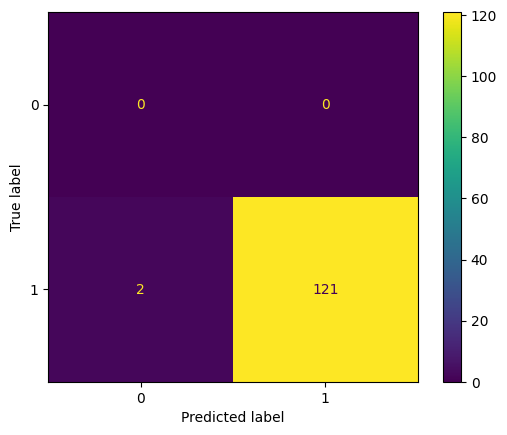


            POTHOLE DETECTION EVALUATION SUMMARY

COCO METRICS:
Mean Average Precision (IoU=0.50:0.95): 0.3750
Mean Average Precision (IoU=0.50): 0.6021
Mean Average Precision (IoU=0.75): 0.4101

SIZE-BASED PERFORMANCE:
mAP for small potholes: 0.1541
mAP for medium potholes: 0.3757
mAP for large potholes: 0.4205

BINARY CLASSIFICATION:
Precision: 1.0000
Recall: 0.9837



In [ ]:
evaluator = PotholeEvaluator(model, test_dataset)
evaluator.evaluate_metrics(confidence_threshold=0.5)

## Visualise predictions

In [ ]:
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as mask_util
import torchvision.transforms as T
from skimage import measure


class PotholeVisualizer:
    def __init__(self, model, test_dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the pothole visualizer

        Args:
            model: Trained MaskRCNN/FasterRCNN model
            test_dataset: PotholeDataset instance for test data
            device: Device to run inference on
        """
        self.model = model
        self.dataset = test_dataset
        self.device = device
        self.model.to(device)
        self.model.eval()

        # Define transforms for inference
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_prediction(self, img_tensor):
        """Run model inference on an image tensor"""
        img_tensor = img_tensor.to(self.device)
        with torch.no_grad():
            prediction = self.model([img_tensor])
        return prediction[0]

    def visualize_sample(self, idx, confidence_threshold=0.5):
        """
        Visualize a single sample with ground truth and predictions

        Args:
            idx: Index of sample in the dataset
            confidence_threshold: Threshold for prediction confidence

        Returns:
            matplotlib figure with the visualizations
        """
        # Get sample from dataset
        sample = self.dataset[idx]

        # Handle different return types from dataset
        if isinstance(sample, tuple) and len(sample) >= 2:
            image = sample[0]  # Assuming image is the first element
            target = sample[1]  # Assuming target is the second element
        elif isinstance(sample, dict):
            image = sample.get('image')
            target = sample.get('target')
        else:
            raise ValueError("Unsupported dataset return type")

        # Store the original image for visualization
        # Convert to numpy array if it's a PIL Image
        if isinstance(image, Image.Image):
            orig_image = np.array(image)
        # Convert to numpy if it's a tensor
        elif isinstance(image, torch.Tensor):
            if image.shape[0] == 3:  # If image is already normalized with shape [3, H, W]
                # Denormalize and convert to numpy
                orig_image = image.permute(1, 2, 0).cpu().numpy()
                # Clip values to [0, 1] range
                orig_image = np.clip(orig_image, 0, 1)
            else:
                orig_image = image.cpu().numpy()
        else:
            orig_image = image.copy()

        # Make sure orig_image is in range [0, 1] or [0, 255]
        if orig_image.max() > 1.0:
            orig_image = orig_image / 255.0

        # Apply transforms for model input
        if isinstance(image, Image.Image) or (isinstance(image, np.ndarray) and image.ndim == 3):
            image_tensor = self.transform(image)
        elif isinstance(image, torch.Tensor):
            if image.shape[0] == 3:  # Already normalized
                image_tensor = image
            else:
                image_tensor = self.transform(Image.fromarray(np.uint8(image)))

        # Get model prediction
        prediction = self.get_prediction(image_tensor)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Plot original image
        axes[0].imshow(orig_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Plot ground truth segmentations
        axes[1].imshow(orig_image)
        self._plot_masks(axes[1], target, is_gt=True)
        axes[1].set_title("Ground Truth Segmentation")
        axes[1].axis("off")

        # Plot predicted segmentations
        axes[2].imshow(orig_image)
        self._plot_masks(axes[2], prediction, is_gt=False, threshold=confidence_threshold)
        axes[2].set_title("Predicted Segmentation")
        axes[2].axis("off")

        plt.tight_layout()
        return fig

    def _plot_masks(self, ax, target_or_pred, is_gt=True, threshold=0.5):
        """Helper function to plot masks on an axis"""
        if is_gt:
            # Handle ground truth masks
            if 'masks' in target_or_pred:
                masks = target_or_pred['masks']
                if isinstance(masks, torch.Tensor):
                    masks = masks.cpu().numpy()

                for mask in masks:
                    # Create polygon from boolean mask
                    if mask.ndim == 3:  # If mask is a 3D tensor (C, H, W)
                        mask = mask[0]  # Take first channel

                    contours = self._get_contours(mask)
                    for contour in contours:
                        # Fill with semi-transparent green
                        poly = Polygon(contour, fill=True, alpha=0.4, color='green', linewidth=2)
                        ax.add_patch(poly)

                        # Add contour line in bright green for better visibility
                        poly_outline = Polygon(contour, fill=False, edgecolor='lime', linewidth=2)
                        ax.add_patch(poly_outline)

            elif 'segmentation' in target_or_pred:
                # Handle COCO-style segmentation polygons
                if isinstance(target_or_pred['segmentation'], list):
                    segmentations = target_or_pred['segmentation']
                    for segm in segmentations:
                        if isinstance(segm, dict):  # RLE format
                            mask = mask_util.decode(segm)
                            contours = self._get_contours(mask)
                            for contour in contours:
                                poly = Polygon(contour, fill=True, alpha=0.4, color='green', linewidth=2)
                                ax.add_patch(poly)

                                poly_outline = Polygon(contour, fill=False, edgecolor='lime', linewidth=2)
                                ax.add_patch(poly_outline)
                        else:  # Polygon format
                            points = np.array(segm).reshape(-1, 2)
                            poly = Polygon(points, fill=True, alpha=0.4, color='green', linewidth=2)
                            ax.add_patch(poly)

                            poly_outline = Polygon(points, fill=False, edgecolor='lime', linewidth=2)
                            ax.add_patch(poly_outline)
                elif isinstance(target_or_pred['segmentation'], dict):  # Single RLE mask
                    mask = mask_util.decode(target_or_pred['segmentation'])
                    contours = self._get_contours(mask)
                    for contour in contours:
                        poly = Polygon(contour, fill=True, alpha=0.4, color='green', linewidth=2)
                        ax.add_patch(poly)

                        poly_outline = Polygon(contour, fill=False, edgecolor='lime', linewidth=2)
                        ax.add_patch(poly_outline)
        else:
            # Handle model predictions
            scores = target_or_pred['scores'].cpu()
            masks = target_or_pred['masks'].cpu()
            keep = scores > threshold

            scores = scores[keep]
            masks = masks[keep]

            # Sort by scores (higher scores on top)
            if len(scores) > 0:
                sorted_indices = torch.argsort(scores, descending=True)
                masks = masks[sorted_indices]
                scores = scores[sorted_indices]

                for i, (mask, score) in enumerate(zip(masks, scores)):
                    mask_np = mask[0].numpy() > 0.5
                    contours = self._get_contours(mask_np)

                    for contour in contours:
                        # Fill with semi-transparent red
                        poly = Polygon(contour, fill=True, alpha=0.4, color='red', linewidth=2)
                        ax.add_patch(poly)

                        # Add contour line in bright red for better visibility
                        poly_outline = Polygon(contour, fill=False, edgecolor='crimson', linewidth=2)
                        ax.add_patch(poly_outline)

                    # Add score text near the largest contour
                    if contours:
                        areas = [len(contour) for contour in contours]
                        largest_idx = np.argmax(areas)
                        largest_contour = contours[largest_idx]
                        centroid = largest_contour.mean(axis=0)
                        ax.text(centroid[0], centroid[1], f"{score.item():.2f}",
                               color='white', fontsize=9, fontweight='bold',
                               bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))

    def _get_contours(self, mask):
        """Get contours from binary mask"""
        # Convert to binary mask if needed
        if not mask.dtype == bool:
            mask = mask > 0.5

        # Find contours
        contours = measure.find_contours(mask.astype(float), 0.5)
        return contours

    def visualize_random_samples(self, num_samples=5, seed=None):
        """
        Visualize random samples from the dataset

        Args:
            num_samples: Number of samples to visualize
            seed: Random seed for reproducibility

        Returns:
            List of matplotlib figures
        """
        if seed is not None:
            random.seed(seed)

        dataset_size = len(self.dataset)
        random_indices = random.sample(range(dataset_size), min(num_samples, dataset_size))

        figures = []
        for idx in random_indices:
            fig = self.visualize_sample(idx)
            figures.append((idx, fig))

        return figures

In [ ]:
# Initialize visualizer
visualizer = PotholeVisualizer(model, test_dataset)

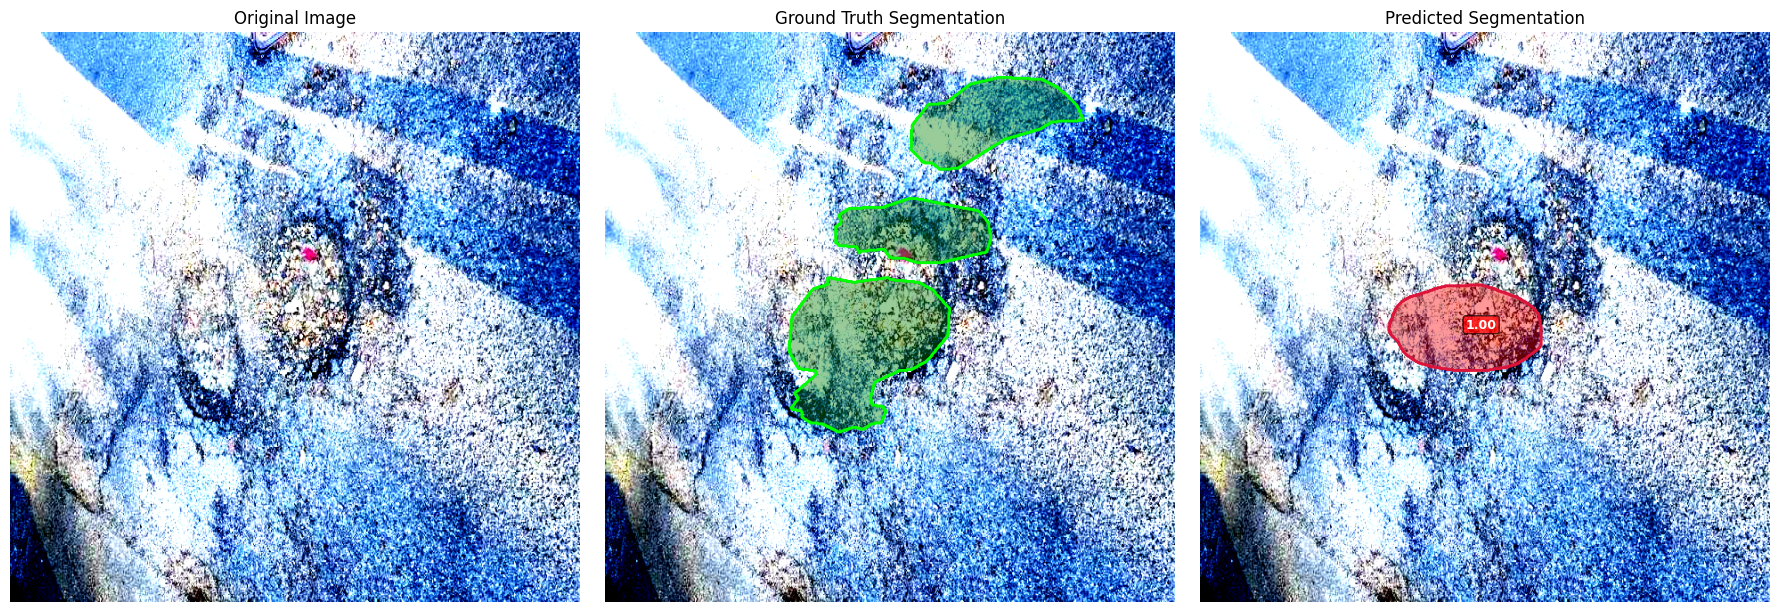

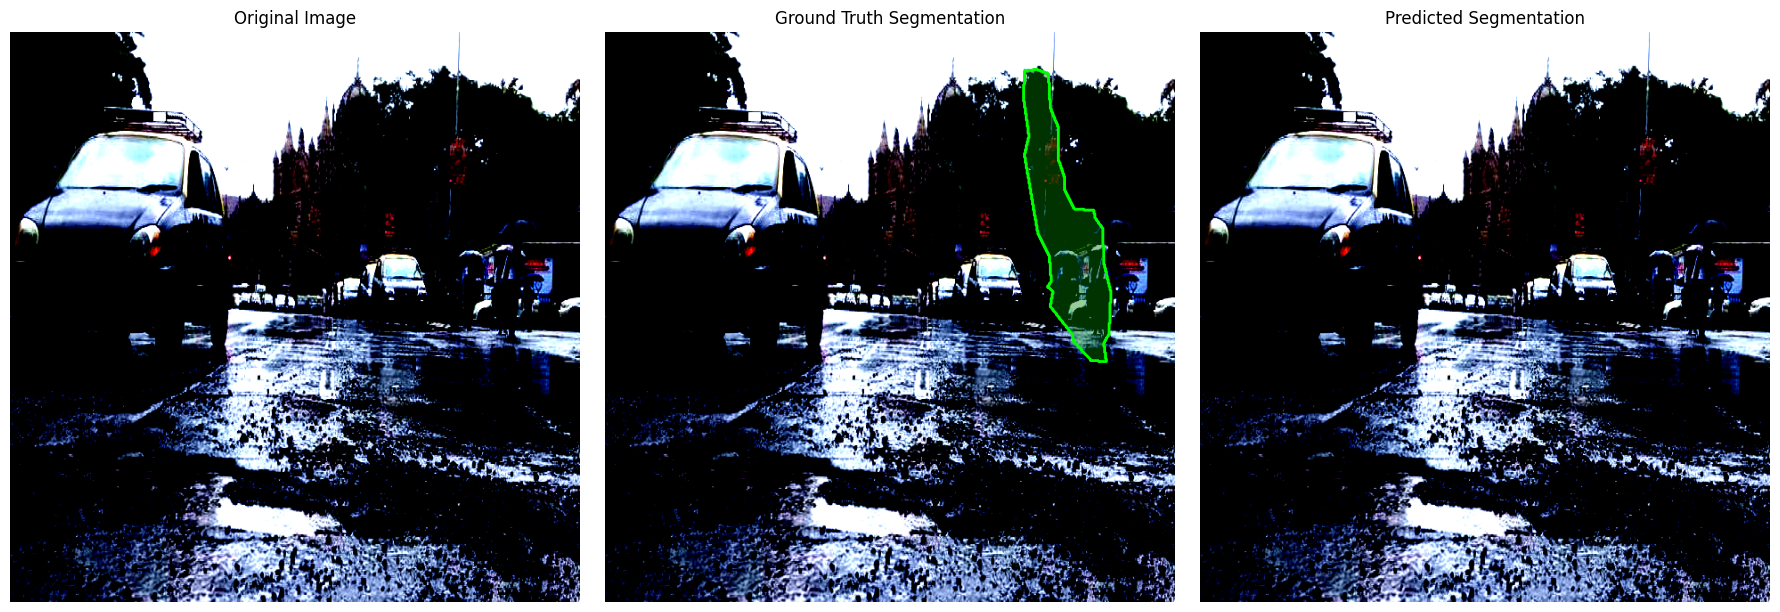

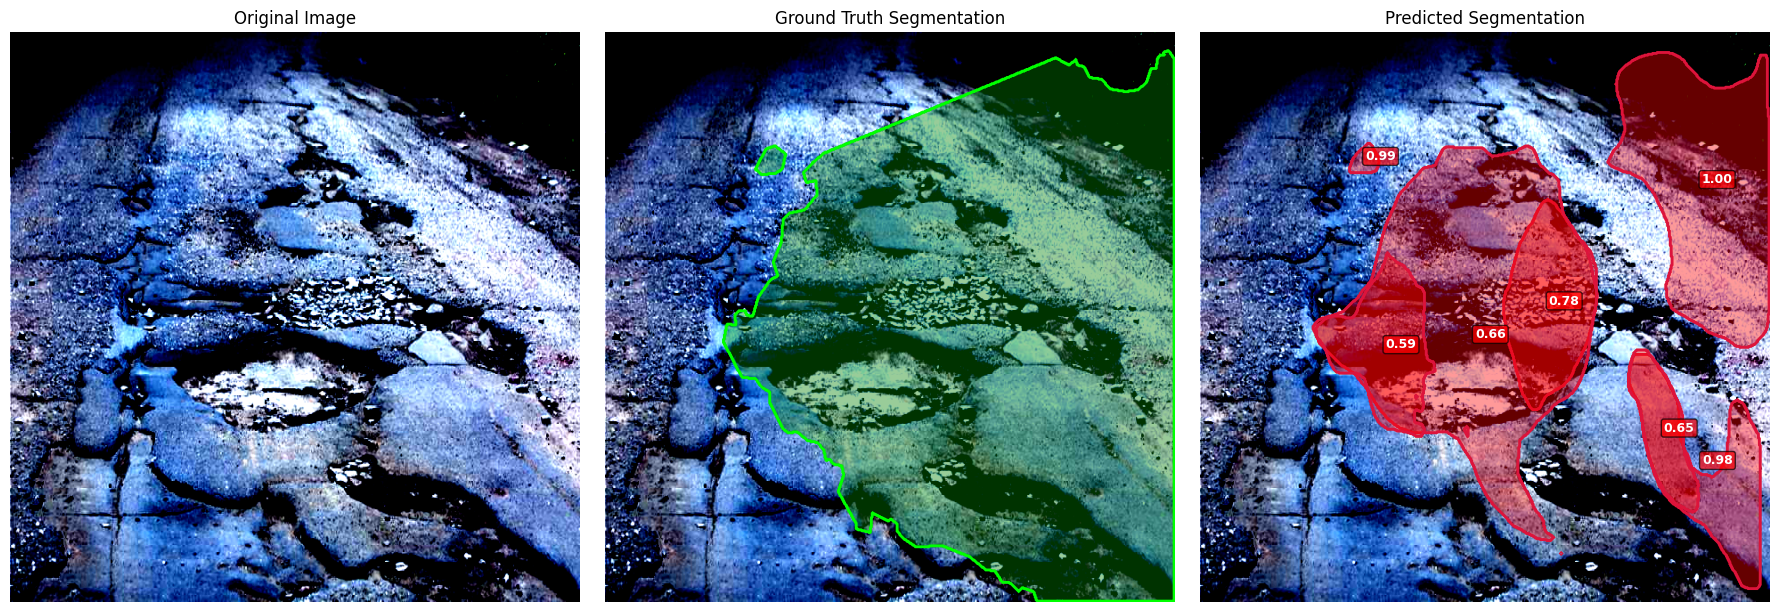

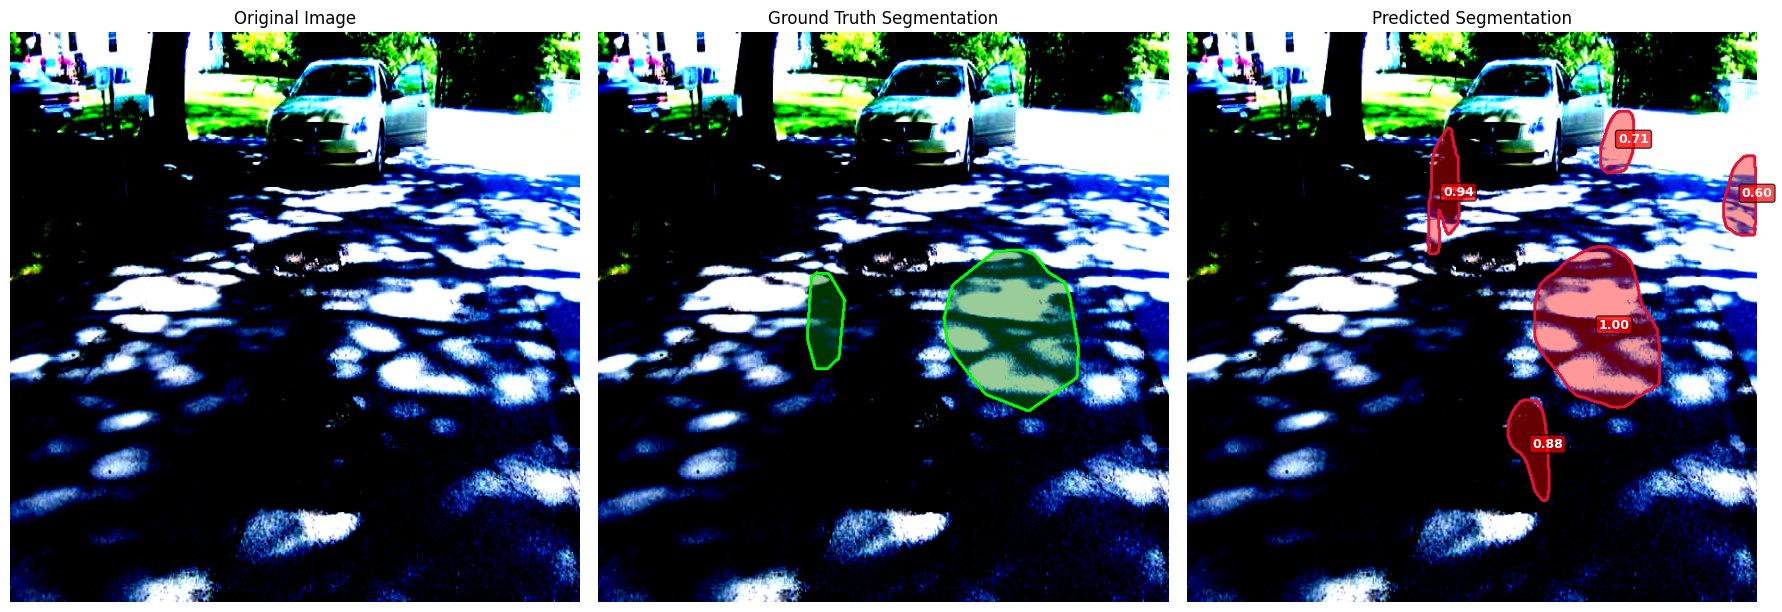

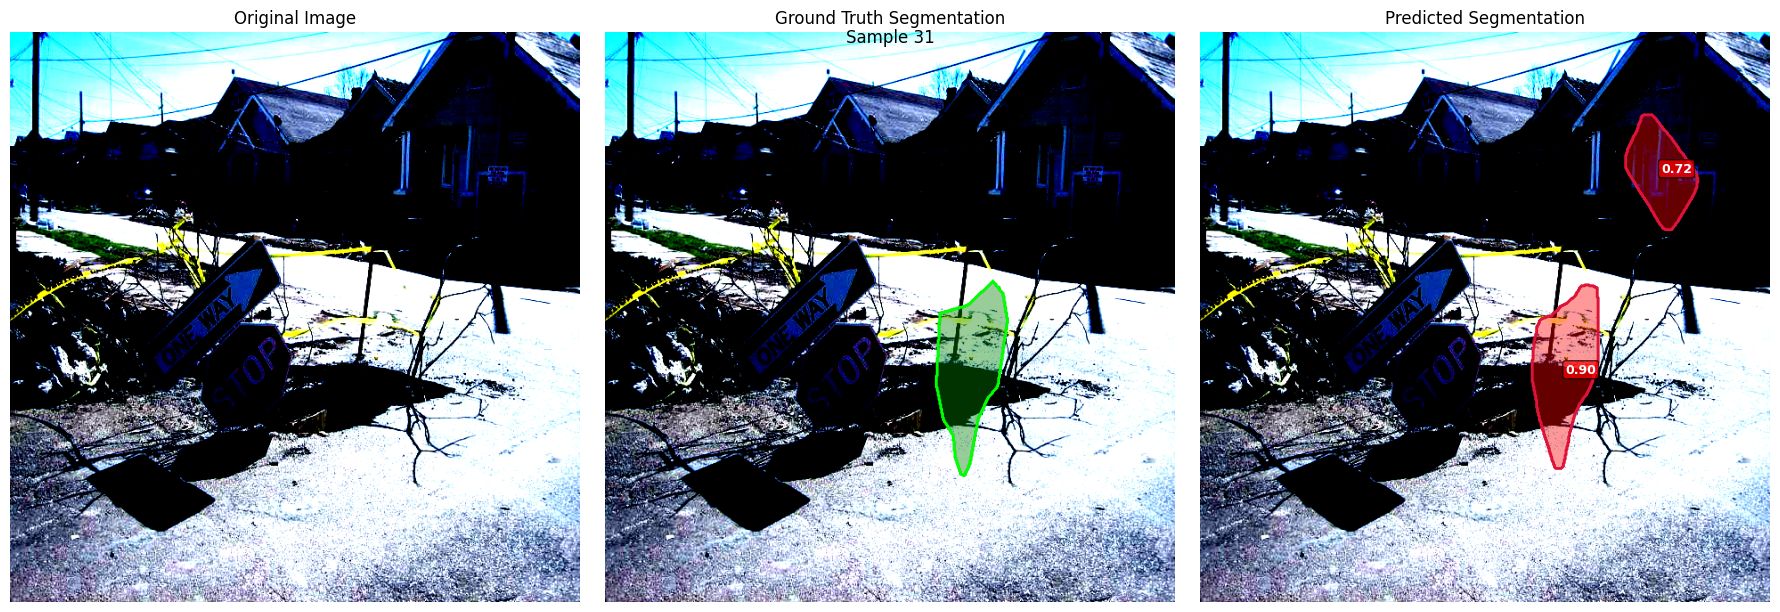

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Visualized 5 random pothole samples


In [ ]:
# Visualize random samples
sample_figures = visualizer.visualize_random_samples(5)

# Display or save the figures
for idx, fig in sample_figures:
    # You can display the figures
    plt.figure(fig.number)
    plt.suptitle(f"Sample {idx}")
    plt.show();

    # Or save them to files
    fig.savefig(f"pothole_visualization_sample_{idx}.png", dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Visualized {len(sample_figures)} random pothole samples")